<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Change Detection Behavior + Optical Physiology </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Tuesday, August 21, 2018</h3> 

<img src="../resources/change_detection_schematic.png" height="400" width="400">  


This notebook will introduce you to the Visual Behavior dataset. This dataset uses 2-photon calcium imaging (also called optical physiology or ophys) to measure neural activity in behaving mice, and was collected for the new Visual Behavior Brain Observatory. Production data collection for the Observatory began in September 2018 and data will be publicly released in 2020.  

The change detection task consists of a series of image presentations. Each image flash is 250ms followed by 500ms of gray screen. The task for the mouse is to lick in a 750ms response window following a change in image identity. On each trial, a change time is scheduled. On go trials, a change in image identity occurs. On catch trials, no image change occurs (aka 'sham change'), and we measure false alarm rates in the same 750ms response window. Correct responses are rewarded and licks outside the response window result in a timeout that delays the next image change.

There are 8 natural scene images shown in each behavioral session, with 4 unique sets of 8 that can be shown in different sessions. One of these image sets has been seen by the mouse many times during initial behavioral training, while the other 3 image sets are seen for the first time under the microscope. 

In this notebook, we will describe the dimensions of the dataset, the core components of each experimental session, and the tools for accessing and analyzing the data. 

You will be working with a single experimental session recorded in a specific cre line and visual area. Other students will have sessions with different areas, cre lines and stimulus sets. As you work through the exercises, compare results with your neighbors to see what the similarities and differences are.

At the end of the notebook, you will compute a value for a metric called lifetime sparseness that measures each neuron's selectivity for stimulus identity, and take the mean across the population of neurons in your experiment session. We will collect the mean sparseness value from each student's unique experiment session to collectively make a plot that compares how sparseness varies across excitatory and inhibitory cell populations, and for stimulus sets that are novel or familiar to the mouse. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p>Let's get started

</div>

In [1]:
# you will need these libraries for computation & data manipulation
import os
import numpy as np
import pandas as pd

# matplotlib is a standard python visualization package
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn is another library for statistical data visualization
# seaborn style & context settings make plots pretty & legible
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white')
sns.set_palette('deep');

# Import allensdk modules for loading and interacting with the data
from allensdk.internal.api import behavior_ophys_api as boa #TODO: We probably won't use this, but instead use the NWB api
from allensdk.brain_observatory.behavior import behavior_ophys_session as bos

from importlib import reload
reload(boa)
reload(bos)

<module 'allensdk.brain_observatory.behavior.behavior_ophys_session' from '/Users/alex.piet/allensdk/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_session.py'>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>The first thing we will do is use the `allensdk` to load a cache for the visual behavior dataset, which contains a manifest describing the dimensions of the dataset and methods for loading the data from particular sessions. You can inspect the manifest contained in the cache to identify experiments of interest and their metadata. 

<p>Make sure you have access to the `visual_behavior_cache.json` file, which tells the cache object where to find the data. </div>

In [2]:
from allensdk.brain_observatory.behavior.swdb import behavior_project_cache as bpc

cache_json = {'manifest_path': '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/SWDB_2019/visual_behavior_data_manifest.csv',
              'nwb_base_dir': '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/SWDB_2019/nwb_files',
              'analysis_files_base_dir': '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/SWDB_2019/extra_files'
              }
cache = bpc.BehaviorProjectCache(cache_json)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.1:**  Get information about what's in the dataset 

<p>Read in 'visual_behavior_data_manifest.csv' using pandas and explore the columns to see the available visual areas, cre lines, and session types. 

</div>

In [3]:
manifest = cache.manifest
manifest.head(10)

,container_id,container_workflow_state,donor_id,full_genotype,sex,created_at,behavior_session_id,equipment_name,ophys_session_name,ophys_experiment_id,ophys_workflow_state,imaging_depth,targeted_structure,stage_name,retake_number
38,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-11-08 20:45:52.011892,775378326,CAM2P.5,20181108_403491_1imagesA,775614751,passed,375,VISp,OPHYS_1_images_A,0.0
39,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-11-13 19:45:53.130447,778166125,CAM2P.5,20181113_403491_2imagesA,778644591,passed,375,VISp,OPHYS_2_images_A_passive,0.0
46,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-12-10 18:40:53.679184,792499741,CAM2P.5,20181210_403491_4imagesB,792812544,passed,375,VISp,OPHYS_4_images_B,2.0
35,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-12-15 19:10:57.996849,796032489,CAM2P.5,20181215_403491_5imagesB,796106850,passed,375,VISp,OPHYS_5_images_B_passive,2.0
37,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-11-29 18:55:48.200392,788017709,CAM2P.5,20181129_403491_6imagesB,788490510,passed,375,VISp,OPHYS_6_images_B,0.0
138,791352433,container_qc,744911447,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,F,2018-12-10 22:55:54.442359,792680306,CAM2P.4,20181210_412036_1imagesA,792815735,passed,175,VISp,OPHYS_1_images_A,0.0
144,791352433,container_qc,744911447,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,F,2018-12-19 01:00:55.101414,798126878,CAM2P.4,20181218_412036_2_images_passive,798404219,passed,175,VISp,OPHYS_2_images_A_passive,1.0
140,791352433,container_qc,744911447,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,F,2018-12-13 22:50:55.961023,794968300,CAM2P.4,20181213_412036_3imagesA,795073741,passed,175,VISp,OPHYS_3_images_A,0.0
141,791352433,container_qc,744911447,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,F,2018-12-14 21:55:54.143808,795742990,CAM2P.4,20181214_412036_4imagesB,795953296,passed,175,VISp,OPHYS_4_images_B,0.0
142,791352433,container_qc,744911447,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,F,2018-12-15 22:25:51.747219,796052844,CAM2P.4,20181215_412036_5imagesB,796108483,passed,175,VISp,OPHYS_5_images_B_passive,0.0


In [4]:
print('targeted structures:', manifest.targeted_structure.unique())
print('\ncre_lines:', manifest.full_genotype.unique())
print('\nstage_types:', manifest.stage_name.unique())

targeted structures: ['VISp']

cre_lines: ['Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt'
 'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt']

stage_types: ['OPHYS_1_images_A' 'OPHYS_2_images_A_passive' 'OPHYS_4_images_B'
 'OPHYS_5_images_B_passive' 'OPHYS_6_images_B' 'OPHYS_3_images_A']


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.2:**  Everyone gets an experiment! 

<p>Get your experiment ID and assign it to a variable called `experiment_id`

<p>What is the `targeted_structure`, `cre_line` and `session_type` for your `experiment_id`? 

</div>

In [5]:
experiment_id = 792812544

# Task 1.2 SOLUTION
row = manifest.loc[manifest['ophys_experiment_id'] == experiment_id]
print(row.targeted_structure.values)
print(row.full_genotype.values)
print(row.stage_name.values)


['VISp']
['Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt']
['OPHYS_4_images_B']


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.3:**  What is in an experiment container? 

<p>The experiment container describes a set of experiment sessions performed at the same location (targeted area and imaging depth) in the same mouse that targets the same set of cells. All the sessions in an experiment container have a common `experiment_container_id`.

<p>Get a the `experiment_container_id` for your `experiment_id` and find out what other sessions were recorded at that same location.

<p>Do all experiment containers have the same number of sessions associated with them? 
</div>

In [6]:
#get the container ID for this experiment
this_container_id = manifest.query("ophys_experiment_id==@experiment_id")['container_id'].values[0]

In [7]:
manifest.groupby('container_id').get_group(this_container_id)

,container_id,container_workflow_state,donor_id,full_genotype,sex,created_at,behavior_session_id,equipment_name,ophys_session_name,ophys_experiment_id,ophys_workflow_state,imaging_depth,targeted_structure,stage_name,retake_number
38,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-11-08 20:45:52.011892,775378326,CAM2P.5,20181108_403491_1imagesA,775614751,passed,375,VISp,OPHYS_1_images_A,0.0
39,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-11-13 19:45:53.130447,778166125,CAM2P.5,20181113_403491_2imagesA,778644591,passed,375,VISp,OPHYS_2_images_A_passive,0.0
46,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-12-10 18:40:53.679184,792499741,CAM2P.5,20181210_403491_4imagesB,792812544,passed,375,VISp,OPHYS_4_images_B,2.0
35,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-12-15 19:10:57.996849,796032489,CAM2P.5,20181215_403491_5imagesB,796106850,passed,375,VISp,OPHYS_5_images_B_passive,2.0
37,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-11-29 18:55:48.200392,788017709,CAM2P.5,20181129_403491_6imagesB,788490510,passed,375,VISp,OPHYS_6_images_B,0.0


In [8]:
# Get number of sessions in each container
manifest.groupby('container_id').size()


container_id
782536745    5
791352433    6
803516615    6
803517529    5
803589437    6
812858755    5
814796558    6
814796612    6
814797528    5
825183217    6
829561794    6
830457573    1
843049827    5
845588020    6
846213087    6
846215539    6
848390542    7
863992815    5
876693136    7
dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The Behavior OPhys Session object</h2>
<p>The BehaviorOphysSession class in allensdk.brain_observatory.behavior.behavior_ophys_session provides an interface to all of the data for a single experimental session from the Visual Behavior pipeline, aligned to a common clock.

<p>We package each session's data into a Neurodata Without Borders 2.0 (NWB) file. The BehaviorOphysSession will load data from the NWB file on-demand and cache it in memory using the methods defined in the BehaviorOphysNwbApi class.

<p>Use help to see what functions are contained in the session object. 


</div>

In [9]:
#from allensdk.brain_observatory.behavior.behavior_ophys_api.behavior_ophys_nwb_api import BehaviorOphysNwbApi as NwbApi

#from allensdk.internal.api.behavior_ophys_api import BehaviorOphysLimsApi

In [10]:
#load data from the corresponding NWB file, retrieve session object
#api = BehaviorOphysLimsApi(experiment_id)
#filepath = api.get_nwb_filepath()
#nwb_exp = NwbApi(filepath)

session = cache.get_session(experiment_id)

In [11]:
help(session)

Help on ExtendedBehaviorSession in module allensdk.brain_observatory.behavior.swdb.behavior_project_cache object:

class ExtendedBehaviorSession(allensdk.brain_observatory.behavior.behavior_ophys_session.BehaviorOphysSession)
 |  Represents data from a single Visual Behavior Ophys imaging session.  LazyProperty attributes access the data only on the first demand, and then memoize the result for reuse.
 |  
 |  Attributes:
 |      ophys_experiment_id : int (LazyProperty)
 |          Unique identifier for this experimental session
 |      max_projection : SimpleITK.Image (LazyProperty)
 |          2D max projection image
 |      stimulus_timestamps : numpy.ndarray (LazyProperty)
 |          Timestamps associated the stimulus presentations on the monitor 
 |      ophys_timestamps : numpy.ndarray (LazyProperty)
 |          Timestamps associated with frames captured by the microscope
 |      metadata : dict (LazyProperty)
 |          A dictionary of session-specific metadata
 |      dff_tra

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.1:**  What is an experiment dataset? 

<p>Use tab completion to see what is in the dataset object for an experiment session

<p>What is in the `metadata` attribute? Make sure it matches what you found in the manifest for this `experiment_id`.

</div>


In [12]:
session.metadata

{'ophys_experiment_id': 792812544,
 'rig_name': 'CAM2P.5',
 'sex': 'F',
 'field_of_view_height': 512,
 'field_of_view_width': 447,
 'targeted_structure': 'VISp',
 'indicator': 'GCAMP6f',
 'LabTracks_ID': 403491,
 'driver_line': ['Slc17a7-IRES2-Cre', 'Camk2a-tTA'],
 'experiment_container_id': 782536745,
 'session_type': 'Unknown',
 'ophys_frame_rate': 31.0,
 'imaging_depth': 375,
 'full_genotype': 'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt',
 'emission_lambda': 520.0,
 'stimulus_frame_rate': 60.0,
 'excitation_lambda': 910.0,
 'age': 'P206',
 'behavior_session_uuid': UUID('ce10f261-93bb-4adf-96ef-bb6e8280ad32'),
 'reporter_line': ['Ai93(TITL-GCaMP6f)'],
 'experiment_datetime': datetime.datetime(2018, 12, 10, 8, 46, 19, tzinfo=tzutc())}

In [13]:
# make sure this is the experiment you selected
print('targeted_structure:', session.metadata['targeted_structure'])
print('driver line:', session.metadata['driver_line'])
print('imaging_depth:', session.metadata['imaging_depth'])

targeted_structure: VISp
driver line: ['Slc17a7-IRES2-Cre', 'Camk2a-tTA']
imaging_depth: 375


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Optical physiology data - max projection, fluorescence traces and roi masks</h2>

<p>Let's use the dataset class to access neuron fluorescence timeseries, roi masks, and metadata. An ROI mask is used to define the boundary of each cell in the flourescence data. The timeseries extracted from each ROI is one cell's activity.


</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 2.2:** Get the maximum intensity projection image using the `max_projection` attribute for your dataset and display it. 
</div>

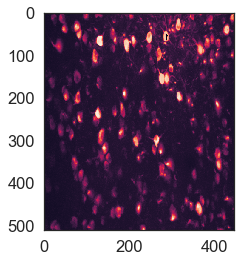

In [16]:
# SOLUTION
maxp = session.max_projection
import SimpleITK as sitk
im_array = sitk.GetArrayFromImage(maxp) # We are hoping to get this updated before SWDB
plt.imshow(im_array)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.3: Get dF/F traces and ophys timestamps**

<p>Get the fluorescence traces and ophys timestamps. What are the dimensions?

<p>`dff_traces` is an array where rows correspond to different cells that were imaged and columns correspond to frames of the 2P movie. `timestamps_ophys` is an array of timestamps for each 2P imaging frame. 

<p>**Note that there are two ways to access this information - by using functions, or directly as attributes of the dataset object. These two methods are shown below. 

</div>

In [17]:
# function method of accessing data
timestamps_ophys = session.ophys_timestamps
dff_traces = session.dff_traces

In [18]:
print('shape of dff_traces:',dff_traces.shape)
print('shape of timestamps_ophys:',timestamps_ophys.shape)

shape of dff_traces: (294, 2)
shape of timestamps_ophys: (141272,)


In [19]:
# you can also skip the step of assigning the attribute to a variable and use the datasest attribute directly
print('shape of dff_traces:',session.dff_traces.shape)
print('shape of timestamps_ophys:',session.ophys_timestamps.shape)

shape of dff_traces: (294, 2)
shape of timestamps_ophys: (141272,)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 2.4: Plot the dF/F trace for a cell**

<p>Plot the dF/F trace for one cell by indexing into the `dff_traces` array. Use `timestamps_ophys` to plot the y_axis in seconds. 

<p>Try plotting the trace for a different cell.

</div>

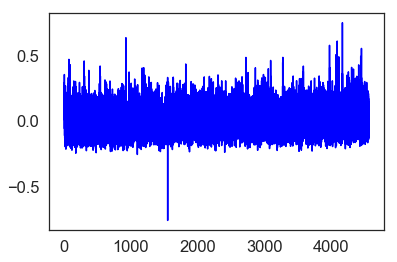

In [20]:
# pick a cell 

# SOLUTION
cell_index = 1
dff = dff_traces.iloc[cell_index]['dff']
plt.plot(timestamps_ophys,dff,'b-')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.5: Going between `cell_index` and `cell_specimen_id`** 
<p>Get the `cell_specimen_id` for your `cell_index` using a function provided in the dataset class. 

<p>Is there a function to translate in the opposite direction?
</div>

In [21]:
#cell_specimen_id = dataset.get_cell_specimen_id_for_cell_index(cell_index)
#print(cell_specimen_id)

In [22]:
# To get the cell specimen ID for an index
# Use df.iloc[] to get rows with particular positions in the index (i.e. use ints starting from zero)
cell_specimen_id = dff_traces.iloc[cell_index].name # The df is indexed by the specimen id. Use the row.name attr to get the index

# df.loc[] gets rows with particular labels in the index. 
dff_traces.loc[cell_specimen_id]

,cell_roi_id,dff
cell_specimen_id,,
NaN,792864548,"[-0.1222441828042272, 0.04866513226579845, -0...."
NaN,792864550,"[0.29146743375403944, 0.2152489083828939, 0.20..."
NaN,792864552,"[0.0736258556483489, 0.07953086002766394, 0.02..."
NaN,792864554,"[0.15608002425218787, 0.13467104068303862, 0.1..."
NaN,792864557,"[0.08954998939306433, 0.11045464957052792, 0.0..."
NaN,792864559,"[0.18075023547558325, 0.3640816183786775, 0.13..."
NaN,792864561,"[0.5051750317009984, -0.023469893053535192, 0...."
NaN,792864563,"[-0.18259644137207456, 0.1858981230856172, 0.2..."
NaN,792864565,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.6: Accessing roi masks** 

<p> 1) Plot the ROI masks for all cells
    
<p> 2) Plot the roi mask for your choosen cell
    
</div>

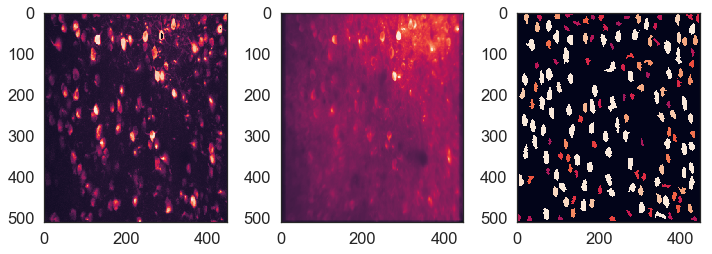

In [27]:
# Plot Mask for all cells
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(10, 5)
ax[0].imshow(sitk.GetArrayFromImage(session.max_projection))
ax[1].imshow(sitk.GetArrayFromImage(session.average_projection))
ax[2].imshow(sitk.GetArrayFromImage(session.segmentation_mask_image))
plt.tight_layout()

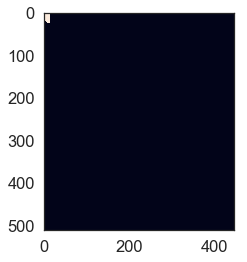

In [31]:
# Plot ROI Mask for one cell
# cell_specimen_ids havent been assigned yet, so we have to use roi_ids
# Get Cell
specimen_table=session.cell_specimen_table
roi_id=792865164

plt.imshow(specimen_table[specimen_table.cell_roi_id==roi_id].image_mask.values[0])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior timeseries and events - running, licks, rewards, and visual stimuli </h2>
<p>As the mouse performs the behavioral task, it is free to run on a disk. The task is a go/no-go style task with licking as the behavioral response. When a mouse correctly licks the water spout, a reward is delivered. 

<p>Running, licks and rewards are measured at the stimulus frame display rate and share timestamps with the stimulus. </div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 3.1: Get running speed trace and timestamps** 

<p>Get the `running_speed` attribute of the dataset object. 

<p>Note that running speed is stored in a dataframe. What are the other columns of this dataframe? 

<p>Runnning speed shares timestamps with the visual stimulus. Compare the values of running timestamps from the `running_speed` dataframe with the values in the dataset attribute `timestamps_stimulus`. 
</div>

In [35]:
session.running_speed

RunningSpeed(timestamps=array([  13.63604,   13.6601 ,   13.67009, ..., 4516.16886, 4516.1886 ,
       4516.19923]), values=array([ 0.        ,  1.87921414,  1.42714319, ..., -0.12092068,
        0.        ,  0.        ]))

In [36]:
print('running speed timestamps:',session.running_speed.timestamps)

running speed timestamps: [  13.63604   13.6601    13.67009 ... 4516.16886 4516.1886  4516.19923]


In [37]:
print('stimulus timestamps:',session.stimulus_timestamps)

stimulus timestamps: <HDF5 dataset "timestamps": shape (269930,), type "<f8">


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.2: Plot running speed**

<p>1) Plot the values for running speed from the `running_speed` column of the dataframe. 

<p>2) Plot the x-axis in seconds, using `timestamps_stimulus` or using the `time` column of the `running_speed` dataframe. 

<p>Running speed is measured in cm/s. Label the axes appropriately.
</div>

Text(0.5, 0, 'Time (s)')

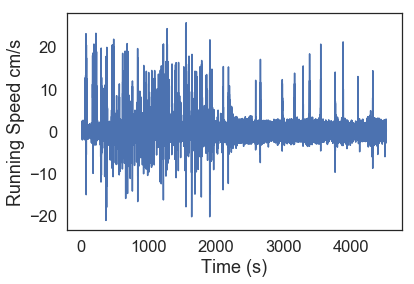

In [38]:
# SOLUTION
plt.plot(session.running_speed.timestamps, session.running_speed.values)
plt.ylabel('Running Speed cm/s')
plt.xlabel('Time (s)')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.3: Plot licking, reward times, and running trace on the same figure**
    
<p>1) Plot `running_speed` as above, but set xlims to focus on a 1 minute portion of the behavior session, from x=600 to x=660. 

<p>2) Plot `rewards` as points (not a line), at y = -10. Set marker='o' and linestyle='None'. Note that `rewards` is a dataframe. Use the values of the `index` column to get x-axis values to plot.

<p>Hint: You will need to create an array of len(session.rewards.index.values) filled with -10 to use as y-axis values to plot. np.repeat() is a convenient function for this.

<p>3) Plot `licking` times using plt.vlines() with ymin=-10 and ymax=-5. 

<p>4) Create a legend. Bonus: place the legend outside of the main figure.

<p>What is the relationship between running, licking and rewards? 
</div>

In [39]:
# Get information about all rewards
session.rewards.head()

,volume,autorewarded
timestamps,,
344.031673,0.007,False
361.261361,0.007,False
449.929279,0.007,False
469.398525,0.007,False
520.437516,0.007,False


In [40]:
# Get information about all licks
session.licks.head()

,time
0,18.84470
1,18.99445
2,24.34456
3,24.49432
4,30.50421


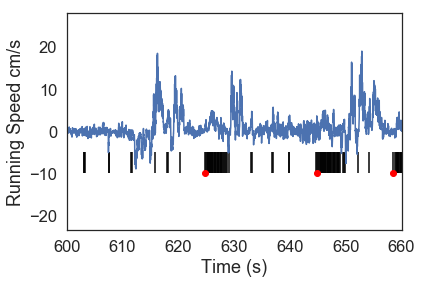

In [41]:
# SOLUTION 
plt.plot(session.running_speed.timestamps, session.running_speed.values)
plt.ylabel('Running Speed cm/s')
plt.xlabel('Time (s)')
plt.xlim(600,660)
plt.plot(session.rewards.index.values, -10*np.ones(np.shape(session.rewards.index.values)),'ro' )
plt.vlines(session.licks,ymin=-10, ymax=-5)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 3.4: Get the stimulus table**

<p>Get the `stimulus_presentations` attribute from the `dataset` object to identify the times of stimulus presentations. How many stimulus flashes were there? 
</div>

In [42]:
session.stimulus_presentations.head()

,duration,end_frame,image_index,image_name,image_set,index,omitted,orientation,start_frame,start_time,...,time_from_last_lick,time_from_last_reward,time_from_last_change,change,block_index,image_block_repetition,index_within_block,licks_each_flash,rewards_each_flash,flash_running_speed
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,0.24970,18001.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,NaN,17986,313.65234,...,12.11495,NaN,NaN,False,0,0,0.0,"[314.01756, 314.14731, 314.31731]",[],-0.098393
1,0.24969,18046.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,1,False,NaN,18031,314.40248,...,0.08517,NaN,NaN,False,0,0,1.0,"[314.51739, 314.66719]",[],0.745761
2,0.25006,18091.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,2,False,NaN,18076,315.15205,...,0.48486,NaN,NaN,False,0,0,2.0,[],[],0.245703
3,0.24995,18136.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,3,False,NaN,18121,315.90203,...,1.23484,NaN,NaN,False,0,0,3.0,[],[],0.149027
4,0.24994,18181.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,4,False,NaN,18166,316.65215,...,1.98496,NaN,NaN,False,0,0,4.0,[],[],0.357506


In [43]:
print('number of stimulus presentations =',len(session.stimulus_presentations))

number of stimulus presentations = 4789


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.5: Plot visual stimulus presentations with behavior events**

<p>1) Copy and paste your code from Exercise 3.3, but now set xlims to zoom in on a 20 second window from t=620 to t=640. 

<p>2) Plot stimulus presentations using the `start_time` and `end_time` columns of the `stimulus_table` with plt.axvspan(). Set alpha=0.3 & facecolor='gray'.

<p>Hint: Loop through each row of the stimulus table to plot all stimulus flashes
    
<p>3) Plot change image presentations using the `image_index` column to compare with the previous image. Set facecolor='blue'

</div>

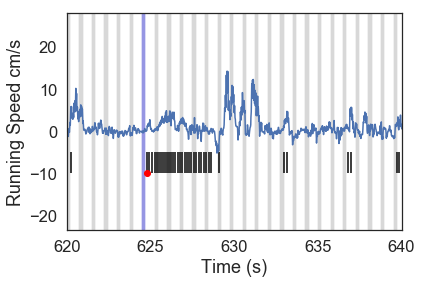

In [44]:
# SOLUTION
plt.plot(session.running_speed.timestamps, session.running_speed.values)
plt.ylabel('Running Speed cm/s')
plt.xlabel('Time (s)')
plt.xlim(620,640)
plt.plot(session.rewards.index.values, -10*np.ones(np.shape(session.rewards.index.values)),'ro' )
plt.vlines(session.licks,ymin=-10, ymax=-5)
image_index = -1
for index,row in session.stimulus_presentations.iterrows():
    plt.axvspan(row.start_time, row.stop_time,alpha=0.3,facecolor='gray')
    if not (row.image_index == image_index):
        plt.axvspan(row.start_time, row.stop_time,alpha=0.3,facecolor='blue')
    image_index = row.image_index

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.5b: Plot visual stimulus presentations with behavior events**

<p>Copy and paste your code from Exercise 3.5a, but now plot a cells dff instead of running speed. You may need to adjust your y-limits

</div>

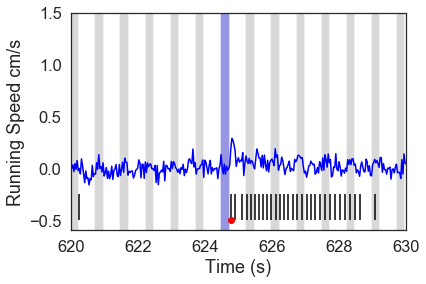

In [66]:
# SOLUTION
cell_index = 2
dff = dff_traces.iloc[cell_index]['dff']
plt.plot(timestamps_ophys,dff,'b-')
plt.ylabel('Running Speed cm/s')
plt.xlabel('Time (s)')
plt.xlim(620,630)
plt.plot(session.rewards.index.values, -0.5*np.ones(np.shape(session.rewards.index.values)),'ro' )
plt.vlines(session.licks,ymin=-0.5, ymax=-.25)
image_index = -1
for index,row in session.stimulus_presentations.iterrows():
    plt.axvspan(row.start_time, row.stop_time,alpha=0.3,facecolor='gray')
    if not (row.image_index == image_index):
        plt.axvspan(row.start_time, row.stop_time,alpha=0.3,facecolor='blue')
    image_index = row.image_index

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 3.6: Get visual stimulus template and metadata**

<p>Get `stimulus_metadata` and `stimulus_template` from the session object. How do they relate to each other?

<p>The first dimension of `stimulus_template` corresponds to the `image_index` in `stimulus_metadata`.
</div>

In [45]:
# This is crashing for an unknown reason
# stimulus_metadata = session.stimulus_index

In [46]:
stimulus_templates = session.stimulus_templates['Natural_Images_Lum_Matched_set_ophys_6_2017.07.14']
np.shape(session.stimulus_templates['Natural_Images_Lum_Matched_set_ophys_6_2017.07.14'])

(8, 918, 1174)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.7: Plot a visual stimulus**

<p>1) Plot an image from the `stimulus_template` using plt.imshow. 

<p>2) Show the `image_name` in the title.

<p>Hint: Use `image_index` to translate between `stimulus_template` and `stimulus_metadata`.

</div>

Text(0.5, 1.0, 'Image_name')

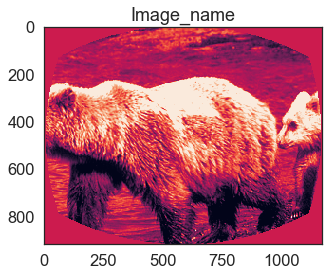

In [47]:
plt.imshow(session.stimulus_templates['Natural_Images_Lum_Matched_set_ophys_6_2017.07.14'][0, :, :])
plt.title('Image_name')


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior trials DataFrame</h2>
<p>The `trials` dataframe organizes behavior events (including licking and rewards), stimulus information (what stimulus was shown before and after the scheduled change time) and metadata (such as whether the trial was a 'go' trial or a 'catch' trial) for each behavioral trial. 

<p>This structure is convenient for data exploration and analysis.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 4.1: Explore the trial records**

<p>1) Get the `trials` attribute of the `session` object. What are the columns of this dataframe? What are the rows?

<p>2) How many trials were there? 

<p>3) How many of those trials had stimulus changes, aka 'go' trials? How many 'catch' trials?

<p>4) What images were shown in this behavior session? 
</div>

In [48]:
session.trials.head()


,start_time,stop_time,trial_length,lick_times,reward_volume,hit,false_alarm,response_time,miss,reward_time,...,stimulus_change,change_time,aborted,go,catch,auto_rewarded,correct_reject,response_latency,initial_image_name,change_image_name
trials_id,,,,,,,,,,,,,,,,,,,,,
0,313.596581,314.980736,1.384156,"[314.01756, 314.14731, 314.31731, 314.51739, 3...",0.0,False,False,NaN,False,NaN,...,False,NaN,True,False,False,False,False,NaN,im000,im000
1,315.097577,318.450168,3.352591,"[317.81723, 317.96699, 318.13726]",0.0,False,False,NaN,False,NaN,...,False,NaN,True,False,False,False,False,NaN,im000,im000
2,318.850642,321.719523,2.868881,"[320.95725, 321.18705, 321.40701]",0.0,False,False,NaN,False,NaN,...,False,NaN,True,False,False,False,False,NaN,im000,im000
3,321.853063,329.109443,7.256379,[],0.0,False,False,NaN,True,NaN,...,True,324.855897,False,True,False,False,False,inf,im000,im106
4,329.359208,330.226573,0.867364,"[329.74718, 329.90712]",0.0,False,False,NaN,False,NaN,...,False,NaN,True,False,False,False,False,NaN,im106,im106


In [49]:
print('number of trials =',len(session.trials))

number of trials = 614


In [50]:
print('number of go trials =',len(session.trials[session.trials.go]))

number of go trials = 242


In [51]:
print('number of catch trials =',len(session.trials[session.trials.catch]))

number of catch trials = 34


In [52]:
images = session.trials.change_image_name.unique()
print(images)

['im000' 'im106' 'im073' 'im035' 'im054' 'im031' 'im075' 'im045']


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 4.2: Get the behavioral response probability for go and catch trials**

<p>Response probability is the fraction of trials where the mouse emitted a lick during the response window. 

<p>The value of the `response` column is a boolean indicating whether or not the mouse emitted a lick on that trial.

<p>1) Select all the 'go' trials by filtering the dataframe by `go`.

<p>2) Count the number of hits for the selected trials to quantify the fraction of 'go' trials where the mouse emitted a behavioral response. 

<p>3) Repeat for 'catch' trials.

<p>***Add your values for response probability on go and catch trials to the plot on the board and draw a line between them***
</div>

In [53]:
# SOLUTION
# Hit % on go trials
go_trials = session.trials[session.trials.go]
print(np.sum(go_trials.hit))
print(len(go_trials))
print(round(np.sum(go_trials.hit)/len(go_trials),2))


71
242
0.29


In [54]:
# SOLUTION
# Correct Rejects on Catch trials
catch_trials = session.trials[session.trials.catch]
print(np.sum(catch_trials.correct_reject))
print(len(catch_trials))
print(round(np.sum(catch_trials.correct_reject)/len(catch_trials),2))

31
34
0.91


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 4.3: Plot response probability across images for go trials**

<p>1) Loop through the image names in `session.trials.change_image_name.unique()`

<p>2) Filter the `trials` dataframe by `change_image_name` and `trial_type` to get 'go' trials for each image.

<p>3) Quantify the fraction of 'go' trials with a `hit` for each image. 

<p>3) Plot the mean response probability for each image. 
</div>

im000
30
im106
30
im073
30
im035
30
im054
30
im031
30
im075
30
im045
32


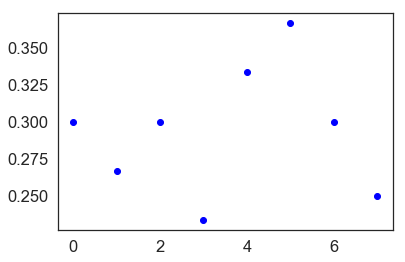

In [55]:
# SOLUTION
hits = []
for image in session.trials.change_image_name.unique():
    print(image)
    image_change_trials = session.trials[(session.trials.change_image_name == image) & session.trials.go]
    print(len(image_change_trials))
    hits.append(np.sum(image_change_trials.hit)/len(image_change_trials))

plt.plot(np.array(hits),'bo')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 4.4: Plot a lick raster**

<p>Provide the `trials` dataframe to the function below to plot a lick raster.

<p>Is the mouse performing the task consistently across the whole session?
</div>

In [56]:
def make_lick_raster(trials):
    fig,ax = plt.subplots(figsize=(5,10))
    for index, trial_data in trials.iterrows(): 
        # get times relative to change time
        trial_start = trial_data.start_time - trial_data.change_time
        lick_times = [(t - trial_data.change_time) for t in trial_data.lick_times]
        reward_time = [(t - trial_data.change_time) for t in [trial_data.reward_time]]
        # plot trials as colored rows
        if trial_data.go:
            ax.axhspan(index, index + 1, -200, 200, color='b', alpha=.1) 
        elif trial_data.catch:
            ax.axhspan(index, index + 1, -200, 200, color='r', alpha=.1) 
        # plot reward times
        if len(reward_time) > 0:
            ax.plot(reward_time[0], index + 0.5, '.', color='b', label='reward', markersize=6)
        if trial_data.catch & (~trial_data.correct_reject):
            ax.plot(trial_data.response_latency, index+0.5, '.', color='r', label='false alarm',markersize=6)
        ax.vlines(trial_start, index, index + 1, color='black', linewidth=1)
        # plot lick times
        ax.vlines(lick_times, index, index + 1, color='k', linewidth=1)
        # annotate change time
        ax.vlines(0, index, index + 1, color=[.5, .5, .5], linewidth=1)
    # gray bar for response window
    ax.axvspan(0.15, 0.75, facecolor='gray', alpha=.3,
               edgecolor='none')
    ax.grid(False)
    ax.set_ylim(0, len(trials))
    ax.set_xlim([-1, 4])
    ax.set_ylabel('trials')
    ax.set_xlabel('time (sec)')
    ax.set_title('lick raster')
    plt.gca().invert_yaxis()

In [57]:
session.trials.dtypes


start_time            float64
stop_time             float64
trial_length          float64
lick_times             object
reward_volume         float64
hit                      bool
false_alarm              bool
response_time         float64
miss                     bool
reward_time           float64
sham_change              bool
stimulus_change          bool
change_time           float64
aborted                  bool
go                       bool
catch                    bool
auto_rewarded            bool
correct_reject           bool
response_latency      float64
initial_image_name     object
change_image_name      object
dtype: object

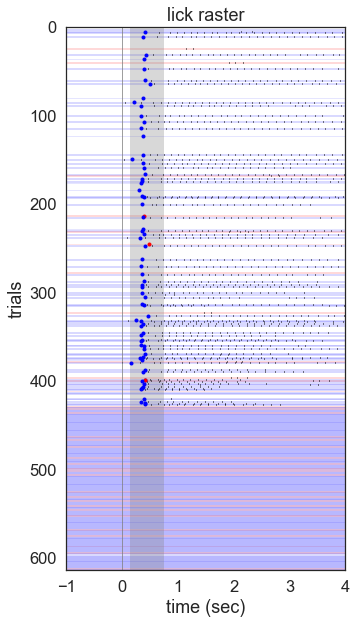

In [58]:
make_lick_raster(session.trials)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The Trial Response and Flash Response dataframes organizes cell responses by behavior trials and stimulus flashes </h2>
<p> The `trial_response_df` extracts cell responses around each behavioral trial.
    
<p> The `flash_response_df` extracts cell responses around each stimulus presentation (flash). 

<p> These two dataframes do all the work of temporal alignment for you. 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 5.1:** Load and explore the Trial Response Dataframe. 

<p>1) Get the `trial_response_df` attribute of the session object. What are the columns? What are the rows? What is different than the `trials` records in the `dataset` object? 
    
<p>The `dff_trace` column contains a portion of each cell's dF/F trace for +/-4 seconds around the `change_time` for each trial. There are also `dff_trace_timestamps` for the same window of time. 

<p> For each trial, the `mean_response` of each cell is computed for a 500ms window after the `change_time`.


<p>2) Assign `trial_response_df` to a variable named `tr` for convenient use in later exercises.
    
</div>

In [67]:
tr = session.trial_response_df

In [68]:
# This dataframe is Cell x Trials 
print(np.shape(tr))
tr.dtypes

(81144, 26)


cell_roi_id             float64
dff_trace                object
dff_trace_timestamps     object
mean_response           float64
baseline_response       float64
start_time              float64
stop_time               float64
trial_length            float64
lick_times               object
reward_volume           float64
hit                        bool
false_alarm                bool
response_time           float64
miss                       bool
reward_time             float64
sham_change                bool
stimulus_change            bool
change_time             float64
aborted                    bool
go                         bool
catch                      bool
auto_rewarded              bool
correct_reject             bool
response_latency        float64
initial_image_name       object
change_image_name        object
dtype: object

In [69]:
tr.head()


cell_roi_id  \
cell_specimen_id trial_id                
792864548        3         792864548.0   
                 5         792864548.0   
                 6         792864548.0   
                 11        792864548.0   
                 24        792864548.0   

                                                                   dff_trace  \
cell_specimen_id trial_id                                                      
792864548        3         [0.2041154228184267, 0.057783784940272455, -0....   
                 5         [-0.018108306249248994, 0.011634581671102644, ...   
                 6         [-0.11090177731092421, 0.13107220601559724, 0....   
                 11        [-0.054107541679430986, -0.17928746954617172, ...   
                 24        [0.06370023751793168, -0.008091906813715502, -...   

                                                        dff_trace_timestamps  \
cell_specimen_id trial_id                                                      
792864548        3         [320.84901, 320.88134, 320.91367, 320.94599, 3...   
                 5         [331.38789, 331.42022, 331.45255, 331.48488, 3...   
                 6         [339.63151, 339.66384, 339.69617, 339.7285, 33...   
                 11        [356.89468, 356.92701, 356.95934, 356.99167, 3...   
                 24        [407.19746, 407.22979, 407.26212, 407.29445, 4...   

                           mean_response  baseline_response  start_time  \
cell_specimen_id trial_id                                                 
792864548        3              0.067986           0.044634  321.853063   
                 5              0.018537           0.049663  330.860472   
                 6              0.087933           0.010911  339.867727   
                 11             0.027679           0.071604  356.381713   
                 24             0.031796           0.001191  408.189966   

                            stop_time  trial_length  \
cell_specimen_id trial_id                             
792864548        3         329.109443      7.256379   
                 5         339.617563      8.757091   
                 6         347.874276      8.006549   
                 11        365.155022      8.773309   
                 24        415.462657      7.272690   

                                                                  lick_times  \
cell_specimen_id trial_id                                                      
792864548        3                                                        []   
                 5                                    [337.49652, 337.68663]   
                 6         [344.02785, 344.27632, 344.4771, 344.60648, 34...   
                 11        [361.25719, 361.50576, 361.71592, 361.85604, 3...   
                 24                                   [412.34447, 412.46459]   

                           reward_volume  ...  stimulus_change  change_time  \
cell_specimen_id trial_id                 ...                                 
792864548        3                 0.000  ...             True   324.855897   
                 5                 0.000  ...             True   335.364422   
                 6                 0.007  ...             True   343.621433   
                 11                0.007  ...             True   360.886111   
                 24                0.000  ...            False   411.192289   

                           aborted     go  catch  auto_rewarded  \
cell_specimen_id trial_id                                         
792864548        3           False   True  False          False   
                 5           False   True  False          False   
                 6           False   True  False          False   
                 11          False   True  False          False   
                 24          False  False   True          False   

                           correct_reject  response_latency  \
cell_specimen_id trial_id                         

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 5.2: Explore the flash response dataframe**

<p>What is in the `flash_response_df` attribute of the analysis object? What are the columns? What are the rows?  How is it different from the `stimulus_table` attribute of the dataset object?

<p>The`flash_response_df` contains the cell responses for individual stimulus presentations, aka flashes. It contains the `mean_response` of every cell in a 500ms window after every stimulus onset, for all stimulus presentations during the behavior session.  

</div>

In [73]:
# Slow to load
fr = session.flash_response_df

In [72]:
fr.head()


cell_roi_id  \
cell_specimen_id flash_id                
792864548        0         792864548.0   
                 1         792864548.0   
                 2         792864548.0   
                 3         792864548.0   
                 4         792864548.0   

                                                                   dff_trace  \
cell_specimen_id flash_id                                                      
792864548        0         [0.06565782801514536, -0.007644254952673487, 0...   
                 1         [0.06338645492420905, 0.16406985467723487, 0.1...   
                 2         [0.06765475193207227, 0.17573360958359838, 0.1...   
                 3         [0.13960455244463635, 0.11160132004060004, 0.0...   
                 4         [0.03775688681309538, -0.01232531206282639, 0....   

                                                        dff_trace_timestamps  \
cell_specimen_id flash_id                                                      
792864548        0         [313.18732, 313.21965, 313.25198, 313.28431, 3...   
                 1         [313.93086, 313.96319, 313.99552, 314.02785, 3...   
                 2         [314.6744, 314.70673, 314.73906, 314.77138, 31...   
                 3         [315.41794, 315.45027, 315.4826, 315.51492, 31...   
                 4         [316.19381, 316.22613, 316.25846, 316.29079, 3...   

                           mean_response  baseline_response  
cell_specimen_id flash_id                                    
792864548        0              0.033993           0.078204  
                 1              0.029474           0.069217  
                 2              0.000282           0.041411  
                 3              0.001808          -0.001583  
                 4              0.044694           0.002769

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Project ideas </h2>
<p>Below is a list of suggested project ideas for working with the Visual Behavior dataset

</div>

* Develop a metric to classify how the mouse's engagement across each session
* Develop a model to predict behavioral performance
* Develop a GLM or other model to predict dff signals from task events
* How well can you decode image identity across different CRE lines?
* How do single cell or population response metrics vary between cre lines, areas or stimulus types? (ex: time-to-peak, reliability, fano factor, noise correlations, signal correlations, representational similarity, etc.)
* Are there distinct or continuous behavioral or neural states within a single behavioral session? (ex: task engagement, expectation, vigilance)
* How do response metrics vary across different states?
* Can different cell response profiles be classified using supervised or unsupervised clustering methods? 
* Do motor signals such as running and licking modulate neural respones in different cre lines or areas?
* Does reward expectation and trial history influence neural or behavioral responses? (ex: time since last reward, outcome of previous trial(s))
* Is there evidence of within session learning for untrained image sets? (behavior_session_B, C, D)
* How do cells respond when a stimulus flash is omitted? 
* Use dimensionality reduction or other methods to visualize the activity of many neurons at once. 